# Text Analytics and NLP Using Graphs

Use a tagged corpus for:
- Supervised: Classification models to classify documents in pre-determined topics
- Unsupervised: Community detection to discover new topics

Chapter covers:
- Provide overview of dataset
- Understand concepts and tools in NLP
- Create graphs from a corpus of documents
- Build a document topic classifier

Dataset:

Reuters-21578 news articles published in newswire in 1987. Has a very skewed distribution, so will use a modified version: ApteMod that has a smaller skew distribution and consistent labels between train and test sets. Each document has a set of labels that represents its content, thus is a perfect benchmark for testing supervised and unsupervised algorithms.

In [1]:
import nltk
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from nltk.corpus import reuters

In [3]:
nltk.download('reuters')

[nltk_data] Downloading package reuters to /home/jupyter/nltk_data...


True

In [4]:
corpus = pd.DataFrame([
    {"id": _id, "clean_text": reuters.raw(_id).replace("\n", ""), "label": reuters.categories(_id)} # remove newline characters
    for _id in reuters.fileids()
]).set_index("id")

In [5]:
corpus.iloc[10]["clean_text"], corpus.iloc[10]["label"]


('SUBROTO SAYS INDONESIA SUPPORTS TIN PACT EXTENSION  Mines and Energy Minister Subroto  confirmed Indonesian support for an extension of the sixth  International Tin Agreement (ITA), but said a new pact was not  necessary.      Asked by Reuters to clarify his statement on Monday in  which he said the pact should be allowed to lapse, Subroto said  Indonesia was ready to back extension of the ITA.      "We can support extension of the sixth agreement," he said.  "But a seventh accord we believe to be unnecessary."      The sixth ITA will expire at the end of June unless a  two-thirds majority of members vote for an extension.  ',
 ['tin'])

In [6]:
from collections import Counter
len(Counter([label for document_labels in corpus["label"] for label in document_labels]).most_common())

90

90 different topics with large class-imbalance, with 37% of documents in most common and 0.01% in each offive least common.

In [7]:
corpus.sample(1)

,clean_text,label
id,,
training/6293,TELEPHONE AND DATA SYSTEMS INC &lt;TDS> YEAR N...,[earn]


## Language Detection
An nlp technique is to look for the most common words (stopwords) and build a score based on its frequency. However, there are many libraries that allow us to infer more elaborate logic

In [9]:
!pip install langdetect

     |████████████████████████████████| 981 kB 19.6 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=ec25b6b09fae7a127b55529a82471b10e8f907afa76b6e08c6b8602b20308fe7
  Stored in directory: /home/jupyter/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [10]:
import langdetect
import numpy as np

def getLanguage(text: str):
    try: 
        return langdetect.detect(text)
    except:
        return np.nan
    
corpus["language"] = corpus["clean_text"].apply(getLanguage)

In [11]:
# there are many languages other than English
# there may be some documents that are short or have a strange structure, so not actually news articles
corpus["language"].value_counts().head(10)

en    9893
sv     434
de     375
sw      29
so      23
nl       8
pt       7
vi       5
et       3
ro       2
Name: language, dtype: int64

In [12]:
# using fasttext to detect language
!curl -w GET https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz > lid.176.ftz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  916k  100  916k    0     0   594k      0  0:00:01  0:00:01 --:--:--  594k


In [13]:
!pip install fasttext

     |████████████████████████████████| 68 kB 7.8 MB/s  eta 0:00:01
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3304894 sha256=4212787fa257c4d7c26fa7de7aa538b27ddb2b0538226165dae0a96c560022f4
  Stored in directory: /home/jupyter/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [14]:
import fasttext

m = fasttext.load_model("lid.176.ftz")
def getLanguage(text: str):
    return m.predict(text)[0][0].replace("__label__", "")

In [15]:
corpus["language"] = corpus["clean_text"].apply(getLanguage)

In [16]:
corpus[corpus["language"]=="ja"].iloc[5]["clean_text"]

'USDA - U.S. 1986/87 ENDING CORN STOCKS  5,240 MLN BU, WHEAT 1,848 MLN, SOYBEANS 610 MLN  USDA - U.S. 1986/87 ENDING CORN STOCKS  5,240 MLN BU, WHEAT 1,848 MLN, SOYBEANS 610 MLN  '

### NLP Enrichment

In [17]:
!pip install spacy

     |████████████████████████████████| 6.3 MB 19.6 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 77.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 86.6 MB/s eta 0:00:01
     |████████████████████████████████| 821 kB 76.4 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 70.0 MB/s eta 0:00:01
     |████████████████████████████████| 457 kB 71.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.6 MB/s  eta 0:00:01
     |████████████████████████████████| 10.2 MB 62.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 11.7 MB/s eta 0:00:01
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.0.0
    Uninstalling smart-open-6.0.0:
      Successfully uninstalled smart-open-6.0.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-r

In [19]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 42.8 MB 1.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [20]:
import spacy

# load model
nlp = spacy.load("en_core_web_md")

In [21]:
# apply model to text
corpus["parsed"] = corpus["clean_text"].apply(nlp)

The parsed object has several fields due to many models being combined to a single pipeline, these provide different levels of text structuring:
-  **Text segmentation and tokenisation**: Aims to split a document into periods, sentences and single words/tokens. Leverages punctuation, blank spaces, newline characters for segmentation. Spacy works fairly well but in practice may require custom rules, such as separation based on hashtags for tweets (TweetTokenizer) etc..
-  **Part-of-Speech Tagger**: Associate each token with PoS tag, its grammatical type - nouns, verbs, adjectives etc.. This mode lhas been trained on previous actual data
-  **Named Entity Recognition (NER)**: Trained to recognise nouns that appear in text, e.g. Organisation, Person, Geographic location etc.. Usually trained on large, tagged dataset that learn common patterns/structures from
-  **Dependency Parser**: Infers relationships between tokens within a sentence, can build a syntax tree of how words are related
-  **Lemmatizer**: Reduces words to common root; reduce word to more stable form for easier processing. Or **Stemmers**: Remove last part of word to reduce to main part of word only

In [22]:
corpus.loc["test/14832"]["clean_text"]

"THAI TRADE DEFICIT WIDENS IN FIRST QUARTER  Thailand's trade deficit widened to 4.5  billion baht in the first quarter of 1987 from 2.1 billion a  year ago, the Business Economics Department said.      It said Janunary/March imports rose to 65.1 billion baht  from 58.7 billion. Thailand's improved business climate this  year resulted in a 27 pct increase in imports of raw materials  and semi-finished products.      The country's oil import bill, however, fell 23 pct in the  first quarter due to lower oil prices.      The department said first quarter exports expanded to 60.6  billion baht from 56.6 billion.      Export growth was smaller than expected due to lower  earnings from many key commodities including rice whose  earnings declined 18 pct, maize 66 pct, sugar 45 pct, tin 26  pct and canned pineapples seven pct.      Products registering high export growth were jewellery up  64 pct, clothing 57 pct and rubber 35 pct.  "

In [23]:
from spacy import displacy

In [24]:
# nice way to utilise entities in text
displacy.render(corpus.loc["test/14832"]["parsed"], style="ent", jupyter=True)

In [26]:
# export
corpus[["clean_text", "label", "language", "parsed"]].to_pickle("corpus.p")

## Graph Generation

Two kinds of graphs from the corupus of documents and information we extracted in the previous:
-  **Knowledge based graphs**: Subject-verb-object (triplet) relation will be encoded to build a semantic graph
-  **Bipartite graph**: Link documents with entities/keywords appearing therein

### Knowledge base

In [29]:
from subject_object_extraction import findSVOs

In [30]:
corpus["triplets"] = corpus["parsed"].apply(lambda x: findSVOs(x))
corpus.sample(1)

,clean_text,label,language,parsed,triplets
id,,,,,
training/7587,"BANK OF SPAIN SUSPENDS ASSISTANCE, DRAINS FUND...","[interest, money-fx, money-supply]",en,"(BANK, OF, SPAIN, SUSPENDS, ASSISTANCE, ,, DRA...","[(bank, suspends, assistance), (bank, suspends..."


In [31]:
edge_list = []
for _id, triplets in corpus["triplets"].iteritems():
    for (source, edge, target) in triplets:
        edge_list.append({"id": _id, 
        "source": [x.lemma_ for x in nlp(source)][0].lower(), 
        "target": [x.lemma_ for x in nlp(target)][0].lower(), 
        "edge": [x.lemma_ for x in nlp(edge)][0].lower()
        })

In [32]:
edges = pd.DataFrame(edge_list)

In [33]:
# most common are basic predicates
edges["edge"].value_counts().head(10)

!          2434
have       1818
include    1776
tell       1459
sell       1100
buy        1081
take        935
make        838
acquire     801
give        713
Name: edge, dtype: int64

In [34]:
# now can create knowledge graph with networkx utility function
import networkx as nx

G=nx.from_pandas_edgelist(edges, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
len(G.nodes)

6361

In [35]:
def plotDistribution(serie: pd.Series, nbins: int, minValue=None, maxValue=None):
    _minValue=int(np.floor(np.log10(minValue if minValue is not None else serie.min())))
    _maxValue=int(np.ceil(np.log10(maxValue if maxValue is not None else serie.max())))
    bins = [0] + list(np.logspace(_minValue, _maxValue, nbins)) + [np.inf]
    serie.hist(bins=bins)
    plt.xscale("log")

def graphSummary(graph, bins=10):
    print(nx.info(graph))
    plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    degrees = pd.Series({k: v for k, v in nx.degree(graph)})
    plt.yscale("log")
    plotDistribution(degrees, bins)
    try:
        plt.subplot(1,2,2)
        allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in graph.edges(data=True)})
        plotDistribution(allEdgesWeights, bins)
        plt.yscale("log")
    except:
        pass

In [36]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 6361
Number of edges: 50095
Average in degree:   7.8753
Average out degree:   7.8753


Name: 
Type: MultiDiGraph
Number of nodes: 6361
Number of edges: 50095
Average in degree:   7.8753
Average out degree:   7.8753


/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6691: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


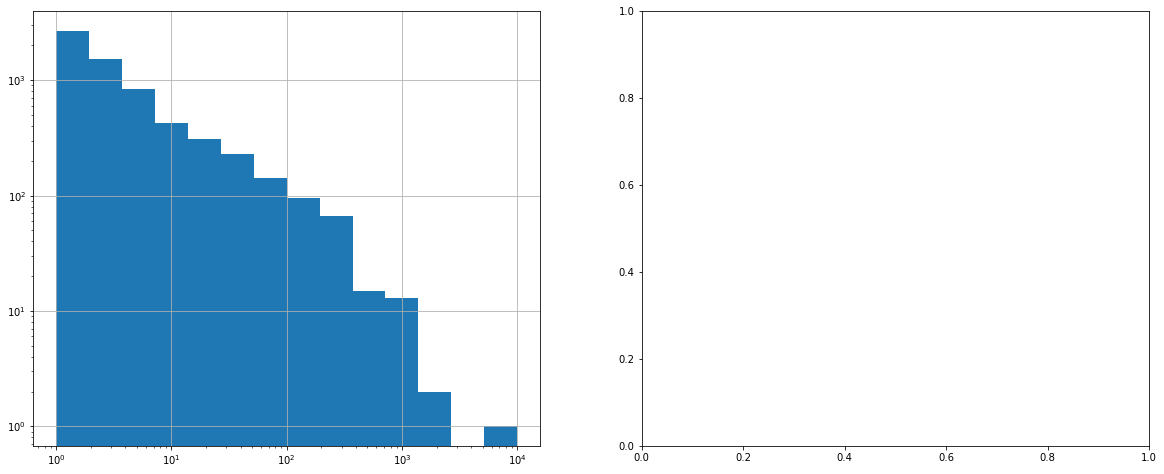

In [37]:
graphSummary(G, bins=15)

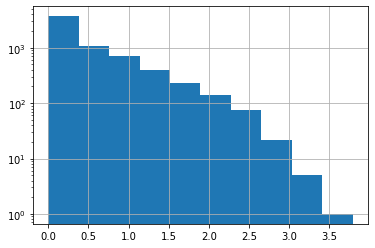

In [38]:
import numpy as np
np.log10(pd.Series({k: v for k, v in nx.degree(G)}).sort_values(ascending=False)).hist()
plt.yscale("log")

In [39]:
edges.head()

,id,source,target,edge
0,test/14826,exporter,damage,fear
1,test/14826,japan,fear,raise
2,test/14826,row,damage,inflict
3,test/14826,they,correspondent,tell
4,test/14826,move,sentiment,boost


In [40]:
# look at edges for 'lend'
e = edges[(edges["source"]!=" ") & (edges["target"]!=" ") & (edges["edge"]=="lend")]

G=nx.from_pandas_edgelist(e, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

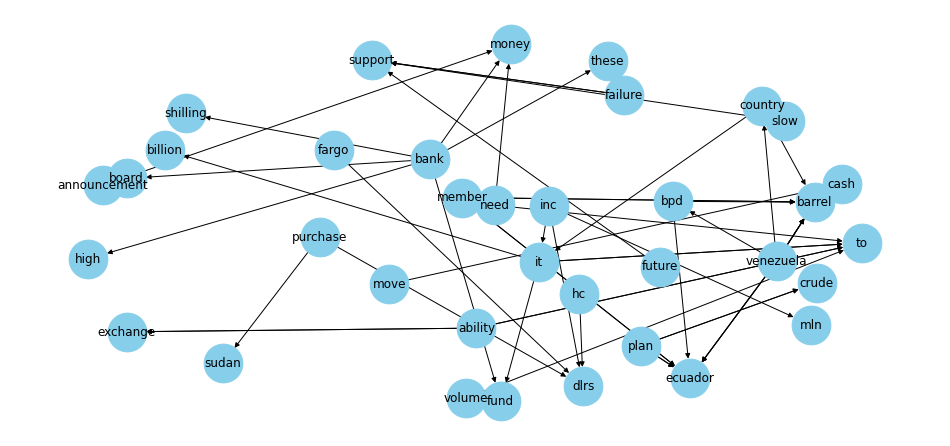

In [41]:
# visualise
import os

plt.figure(figsize=(13, 6))

pos = nx.spring_layout(G, k=1.2) # k regulates the distance between nodes

nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_size=12)

# plt.show()
# plt.savefig(os.path.join(".", "KnowledgeGraph.png"), dpi=300, format="png")

### Bipartite Graph
Encode information in a **bipartite graph**. Extract entities that are relevant and connect a node, representing a document with all nodes representing the relevant entities in a document. So a node may have multiple connections, and an entity can be referenced in multiple documents. So we can use a similarity measure to project bipartite graph into one particular set of nodes, either the document or entity nodes.

A *relevant entity* is fuzzy and broad. One way to determine important keywords is TF-IDF, to count the frequency of words (**Term Frequency**) to the inverse of the frequency across a corpus of documents **Inverse dovument frequency**.

($c$<sub>$i,j$ / $\sum c$ <sub>$i,j$</sub>$)$</sub>$\cdot log(N/1+D_i)$

c_ij represents the count of word i in document j, N the number of documents in the corpus and Di the document where word i appears. So TF-IDF promotes words repeated many times in a document, penalising words that are common so might not be so representative for a document. 

There are also other methods to rank text, one is **TextRank** which is based on graph representation of a document, where tokens are a node and the edges are tokens within a certain window. After, PageRank is use to compute centrality for each token; allowing then a ranking within document based on centrality. Most central nodes (ratio generally 5-20%) are identified as candidate keywords. When two cancidate keywords occur close to each other, they get aggregated to composite tokens.

In [68]:
import gensim
from gensim.summarization import keywords 

In [69]:
text = corpus["clean_text"][0]
keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)

TypeError: object of type 'Graph' has no len()

Score represents centrality; and can parse entity functions with Spacy. Then finally create networkx with nodes of source and target with the words between. 

Be careful of entities that only appear once or twice but still generate cliques within graph, also of weighted edges.. Peaked degree distribution and spikes in edge weights show presence of small communities (cliques) which are conected via some central nodes. So we can introduce some threshold to consider the edges only with the largest weights, and this reduces our edges significantly, so is more feasible toanalyse.

Can compute global measures to analyse, shortest path, clustering efficiency, global efficiency. Plot relationship between degree and page rank, betweenness centrality measures etc.. Also using Louvain community detection to identify best partitions of nodes in disjoint communities, and we observe about 30 commnities with the larger ones having 130-150 documents. 

Can use this to identify topology and similarity between entities using node embeddings. Some differences with Word2Vec and Node2Vec; Node2Vec encodes description that acts more at document level since it comes from bipartite entity-document graph and Word2Vec is built directly from text and encloses relationships at sentence level.

### Document-Document Graph

Plotting the degree distribution we see a few with very high degrees, indicating the presence of super-nodes, nodes which are very highly connected. Entity-entity graph characterised by many tightly connected communities, the document-document graph is characterised by light connection among nodes with a large degree (which constitutes the core) vs. a periphery of weakly connected or disconnected nodes.

## Building a Document Topic Classifier
-  **Shallow machine-learning approach**: Using embeddings extracted from bipartite network to train traditional classifier
    - Node2Vec to extract embeddings; transductive aswe compute embeddings over entire dataset
    - Can compute embeddings beforehand so is faster during training of model
    - Can integrate embeddings into sklearn BaseEstimator, have fit, transform and fit_transform
    - Then create sklearn pipeline and parameter space for grid search & fine-tuning
-  **More integrated and differentiable approach**: Using GNNs applied to heterogenous graphs (such as bipartite graph)
    - This is more inductive (don't know test samples at training time) and can apply to heterogenous graphs, graphs with >1 type of node
    - GraphSage can incorporage model features also, here TF-IDF scores ae used for each vector
    - Stop training after validation accuracy stops increasing so much, to prevent overfitting
    - See substantial (5-10%) improvement over shallow embedding method.